In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
inputs = np.array([
    [0,0,0,0],
    [1,1,1,1],
    [0,1,1,0],
    [1,0,0,1]
]) # Input samples, sample i is inputs[i,:]
targets = np.array([
    [0,0,0,1],
    [0,0,1,0],
    [0,1,0,0],
    [1,0,0,0]
]) # Corresponding targets, inputs[i,:] has the corresponding target of target[i,:]

In [3]:
# Parameters
N_hidden_layers = 1 # number of hidden layers
N_layers = N_hidden_layers + 2 # i'm adding an extra layer for input and output, hence the +2
N_hidden_neurons = 256 # number of hidden neurons per layer (for simplicity, assume all hidden layers have same # neurons)
N_epochs = 1000 # Train for some number of epochs
learning_rate = 0.1 # A learning rate which seems to work

# An array to store the number of neurons per layer = [input size, N_hidden_neurons, ..., N_hidden_neurons, output size]
input_size = inputs.shape[1]
output_size = targets.shape[1]
N_neurons_perLayer = [input_size] + [N_hidden_neurons for _ in range(N_hidden_layers)] + [output_size]

# For plotting
error_overTime = np.zeros(N_epochs)

In [4]:
# 2D array of neurons representing our network
# Neuron i in layer j is neurons[j][i]
neurons = np.zeros(shape=(N_layers, N_hidden_neurons))
# the input and output layers have less than N_hidden_neurons, but it's easier to keep the matrix square
# so the 2D matrix has more spaces in the first and last rows than it needs, just ignore the left over

# Weights for the network, randomly initialized between -.1 and .1, good to be small and random
weights = np.random.uniform(low=-.1,high=0.1,size=[N_layers-1,N_hidden_neurons,N_hidden_neurons])
# There are weights between each layer of neurons, so a total of N_layers-1
# Assume fully-connected, so there are N_hidden_neurons^2 weights between each layer
# weights[L][i][j] is the weight from neuron i in layer L, to neuron j in layer L+1

# again, the first and last layers don't use all the weights as they have fewer neurons, but 
# keep the matrix rectangular and ignore the left over

In [5]:
# For backpropagation we are going to compute a number of gradients
# taken from video: https://www.youtube.com/watch?v=VCT1N0EsGj0

# dE / dy , the error with respect to the value of a neuron (how the error changes if we change the value of this neuron)
dEdy = np.zeros(shape=(N_layers,N_hidden_neurons))

# dE / dz , the error with respect to the input to a neuron (how the error changes if we change the input to this neuron)
dEdz = np.zeros(shape=(N_layers,N_hidden_neurons))

# dE / dw , the error with respect to a weight (how the error changes if we change the values of this weight)
dEdw = np.zeros(shape=(N_layers,N_hidden_neurons, N_hidden_neurons))

# We first compute dE/dy for neurons in a layer
# Use that to compute dE/dz for their inputs
# Then use that (plus the value of neurons in previous layer) to compute the dE/dw for the weights
# this dE/dw is the called the gradient
# gradient descent is updating our weights in the direction of the gradient to lower the error

In [6]:
# Train
for epoch in range(N_epochs):
    # Take one sample at a time
    for sampleIndex in range(inputs.shape[0]):
        sample = inputs[sampleIndex,:] # Input sample
        target = targets[sampleIndex,:] # What the output should be
        
        # Set the input neurons
        for i in range(inputs.shape[1]):
            neurons[0][i] = sample[i] # Set the neurons to the integers in sample
        
        ########### Forward propagate ######################################################
        for L in range(1, N_layers): # For each layer
            # Computing the value of neurons in layer L
            for i in range(N_neurons_perLayer[L]): # For each neuron in that layer
                z = 0 # Start at 0
                # Compute the weighted sum of neurons in previous layer to this neuron
                for j in range(N_neurons_perLayer[L-1]): # For each neuron in previous layer
                    n = neurons[L-1][j] # Neuron in previous layer
                    w = weights[L-1][j][i] # Weight from previous layer, neuron j, to this neuron i
                    z += n * w
                # After completing weight sum, do non-linear activation
                value = 1 / ( 1 + np.exp(-z)) # take the sigmoid function of the sum
                neurons[L][i] = value # Done computing this neuron, save it
        ########### End Forward propagate ######################################################
        
        
        ########### Back propagate ######################################################
                
        # Now that forward propagation is done, the output neurons are supposed to be close to the target
        # Start by finding the error, the difference between target and the value of the neurons
        # Generally, y is going to correspond to the value of a neuron, t is the target for a single neuron
        # We define the error as the squared error
        # E = 1/2 * (t - y)^2
        # The value of this function is it has a nice derivative
        # dE/dy = -(t - y)
        # And this is where we start getting our gradients that we can use to update the weights
        
        # Compute dE/dy for the output layer
        outputLayer = N_layers-1
        for i in range(output_size): 
            y = neurons[outputLayer][i] # value of this output neuron
            dEdy[outputLayer][i] = -(target[i] - y) 
            
        # Each neuron has a dE/dy, now we can use its own value to compute its dE/dz 
        for i in range(output_size):  
            # since y (the value of a neuron) is computed as a sigmoid
            # it's derivative with respect to its input z (the weighted sum)
            # is y*(1-y) 
            # because if f(x) = sigmoid(x)
            # df(x)/dx = f(x)*(1-f(x)) by definition
            
            # Value of neuron
            y = neurons[outputLayer][i]
            # dy/dz of the neuron
            dydz = y*(1-y)
            # dE/dz = dy/dz*dE/dy
            dEdz[outputLayer][i] = dydz * dEdy[outputLayer][i]
            
        # Now, we have dE/dz for the output layer
        # We can work backwards through the network, computing gradients based on these gradients
        for L in range(N_layers-2,-1,-1): # Start at 2nd last and go back to 0 (the input layer)
            # For each neuron in this layer
            for i in range(N_neurons_perLayer[L]): # neuron i of this layer L
                # We know the dE/dz for the following (next) layer 
                # That is the  gradient of error for the inputs to those neurons
                # We can now compute the dE/dy for THESE neurons, since we know how they impact the next neurons
                # dE/dy =  SUM (w*dE/dz)
                # the dE/dy of neuron in this layer, is the sum of its weights to neurons in the next layer
                # times their dE/dz
                # intuition: How the value of this neuron affects the error
                # is how it impacts the error on the input to the next layer
                s = 0 # The sum
                # For each neuron in NEXT layer
                for j in range(N_neurons_perLayer[L+1]):
                    w = weights[L][i][j] # The weight from this neuron to neuron j in next layer
                    s += w * dEdz[L+1][j] # dE/dz of neuron j in next layer
                dEdy[L][i] = s # The sum of all its weights times dE/dzs of next layer
                # We can also immediately compute its own dE/dz by rule previously mentioned
                y = neurons[L][i]
                dEdz[L][i] = y*(1-y)*dEdy[L][i] # it's based on its own dE/dy
                
                # Where it all comes together, this is where the weight gradients can be computed
                # Now that we have dE/dz for neurons in THIS layer, we can compute the gradients
                # of the weights leaving it
                # For each neuron in NEXT layer
                for j in range(N_neurons_perLayer[L+1]):
                    # neuron i of this layer, neuron j of next layer
                    # We need the gradient for weight (w) from this neuron i to neuron j in next layer
                    # We already know dE/dz of the next layer, because we computed that earlier
                    # We have the formula
                    # dE/w = dz/dw*dE/dz 
                    # The gradient of this weight, is how z (input of next layer) changes with respect to this weight
                    # times dE/dz (the gradient of the input to neuron j in next layer, which is already computed)
                    # so dz/dw is the only unknown, how the input of next layer neuron j changes with this weight
                    # but we DO know
                    # The input to neuron j (z) is a weighted sum of neurons times weights
                    # So how that input changes with respect to this weight, is the value of this neuron i
                    # because neuron i times this weight goes into neuron j's input
                    # so dz/dw = y , simply the value of this neuron
                    y = neurons[L][i] # This neuron i's value
                    dEdw[L][i][j] = y * dEdz[L+1][j]
                    # This weights gradient, layer L neuron i to layer L+1 neuron j
                    # is the value of neuron i, times dE/dz of neuron j
                    
        ########### End Back propagate ######################################################
        
        ########### Update weights ######################################################
        # Now forward and back propagation is done  
        # We have computed the gradients for all the weights
        # Now we can update (doing batch size = 1, update gradients after every input)
        for L in range(N_layers-1):
            for i in range(N_neurons_perLayer[L]):
                for j in range(N_neurons_perLayer[L+1]):
                    weights[L][i][j] -= learning_rate * dEdw[L][i][j]
                    # For all weights, subtract the gradient times a learning rate
                    # Go in the direction (up or down) such that the error is more negative
        ########### End update weights ######################################################
                    
                
    ############## Extra, compute the error after every epoch
    # After each epoch, test the total error
    total_error = 0
    es = [0,0,0,0]
    for sampleIndex in range(inputs.shape[0]):
        sample = inputs[sampleIndex,:] # Input sample
        target = targets[sampleIndex,:] # What the output should be        
        # Set the input neurons
        for i in range(inputs.shape[1]):
            neurons[0][i] = sample[i] # Set the neurons to the integers in sample      
        ########### Forward propagate ######################################################
        for L in range(1, N_layers): # For each layer
            # Computing the value of neurons in layer L
            for i in range(N_neurons_perLayer[L]): # For each neuron in that layer
                z = 0 # Start at 0
                # Compute the weighted sum of neurons in previous layer to this neuron
                for j in range(N_neurons_perLayer[L-1]): # For each neuron in previous layer
                    n = neurons[L-1][j] # Neuron in previous layer
                    w = weights[L-1][j][i] # Weight from previous layer, neuron j, to this neuron i
                    z += n * w
                # After completing weight sum, do non-linear activation
                value = 1 / ( 1 + np.exp(-z)) # take the sigmoid function of the sum
                neurons[L][i] = value # Done computing this neuron, save it
        ########### End Forward propagate ######################################################
        # Report the error so we can see if it's improving
        serror = 0
        for i in range(output_size):
            serror += 1/2* (target[i]-neurons[N_layers-1][i])**2
        total_error += serror
        es[sampleIndex] = serror
        
    print("Epoch", epoch, "Total error was", total_error)       
    error_overTime[epoch] = total_error

Epoch 0 Total error was 1.5081602522319972
Epoch 1 Total error was 1.5207126624075
Epoch 2 Total error was 1.5279715886129708
Epoch 3 Total error was 1.5305856390610937
Epoch 4 Total error was 1.5311270125929284
Epoch 5 Total error was 1.5307539091415816
Epoch 6 Total error was 1.5299741866569772
Epoch 7 Total error was 1.529012308461558
Epoch 8 Total error was 1.5279679710123877
Epoch 9 Total error was 1.5268855044879874
Epoch 10 Total error was 1.5257845858131387
Epoch 11 Total error was 1.5246739049504427
Epoch 12 Total error was 1.5235572571195286
Epoch 13 Total error was 1.5224362587341427
Epoch 14 Total error was 1.521311557222595
Epoch 15 Total error was 1.5201833693136793
Epoch 16 Total error was 1.5190517202127802
Epoch 17 Total error was 1.5179165497207467
Epoch 18 Total error was 1.5167777592450826
Epoch 19 Total error was 1.5156352325915967
Epoch 20 Total error was 1.5144888451422809
Epoch 21 Total error was 1.513338467896458
Epoch 22 Total error was 1.5121839692432828
Epoc

Epoch 190 Total error was 1.1038915472039894
Epoch 191 Total error was 1.0991652944026806
Epoch 192 Total error was 1.0944058003694366
Epoch 193 Total error was 1.089613215796264
Epoch 194 Total error was 1.084787697145668
Epoch 195 Total error was 1.0799294065572327
Epoch 196 Total error was 1.075038511787065
Epoch 197 Total error was 1.0701151861841653
Epoch 198 Total error was 1.0651596087077049
Epoch 199 Total error was 1.0601719639890503
Epoch 200 Total error was 1.055152442442182
Epoch 201 Total error was 1.0501012404259003
Epoch 202 Total error was 1.0450185604608961
Epoch 203 Total error was 1.0399046115043986
Epoch 204 Total error was 1.03475960928467
Epoch 205 Total error was 1.029583776697125
Epoch 206 Total error was 1.0243773442633175
Epoch 207 Total error was 1.0191405506534068
Epoch 208 Total error was 1.013873643272103
Epoch 209 Total error was 1.0085768789073546
Epoch 210 Total error was 1.0032505244403505
Epoch 211 Total error was 0.9978948576146207
Epoch 212 Total er

Epoch 378 Total error was 0.2427703692145229
Epoch 379 Total error was 0.24083919865163744
Epoch 380 Total error was 0.23893069763906144
Epoch 381 Total error was 0.2370445606150995
Epoch 382 Total error was 0.23518048555672116
Epoch 383 Total error was 0.23333817399053963
Epoch 384 Total error was 0.23151733100034794
Epoch 385 Total error was 0.22971766523139533
Epoch 386 Total error was 0.22793888889159183
Epoch 387 Total error was 0.22618071774981244
Epoch 388 Total error was 0.22444287113147188
Epoch 389 Total error was 0.2227250719115293
Epoch 390 Total error was 0.22102704650507995
Epoch 391 Total error was 0.21934852485568296
Epoch 392 Total error was 0.21768924042156582
Epoch 393 Total error was 0.21604893015984328
Epoch 394 Total error was 0.21442733450888418
Epoch 395 Total error was 0.21282419736894426
Epoch 396 Total error was 0.21123926608119295
Epoch 397 Total error was 0.2096722914052415
Epoch 398 Total error was 0.20812302749528583
Epoch 399 Total error was 0.2065912318

Epoch 562 Total error was 0.08374743392845217
Epoch 563 Total error was 0.08339885444758471
Epoch 564 Total error was 0.0830527293375436
Epoch 565 Total error was 0.0827090349261743
Epoch 566 Total error was 0.08236774782598728
Epoch 567 Total error was 0.0820288449301259
Epoch 568 Total error was 0.0816923034083967
Epoch 569 Total error was 0.0813581007033653
Epoch 570 Total error was 0.08102621452651312
Epoch 571 Total error was 0.08069662285445602
Epoch 572 Total error was 0.08036930392522348
Epoch 573 Total error was 0.08004423623459578
Epoch 574 Total error was 0.07972139853250075
Epoch 575 Total error was 0.07940076981946673
Epoch 576 Total error was 0.07908232934313167
Epoch 577 Total error was 0.0787660565948077
Epoch 578 Total error was 0.07845193130610008
Epoch 579 Total error was 0.07813993344557878
Epoch 580 Total error was 0.07783004321550292
Epoch 581 Total error was 0.07752224104859617
Epoch 582 Total error was 0.07721650760487392
Epoch 583 Total error was 0.076912823768

Epoch 745 Total error was 0.0455230737454795
Epoch 746 Total error was 0.04540111354463249
Epoch 747 Total error was 0.0452797240344661
Epoch 748 Total error was 0.04515890147101357
Epoch 749 Total error was 0.04503864214162054
Epoch 750 Total error was 0.04491894236462815
Epoch 751 Total error was 0.0447997984890605
Epoch 752 Total error was 0.04468120689431636
Epoch 753 Total error was 0.044563163989863104
Epoch 754 Total error was 0.04444566621493596
Epoch 755 Total error was 0.04432871003823897
Epoch 756 Total error was 0.044212291957651126
Epoch 757 Total error was 0.04409640849993486
Epoch 758 Total error was 0.043981056220448005
Epoch 759 Total error was 0.04386623170285947
Epoch 760 Total error was 0.043751931558868265
Epoch 761 Total error was 0.04363815242792533
Epoch 762 Total error was 0.04352489097695901
Epoch 763 Total error was 0.04341214390010319
Epoch 764 Total error was 0.04329990791842943
Epoch 765 Total error was 0.04318817977968102
Epoch 766 Total error was 0.04307

Epoch 924 Total error was 0.030219228163140106
Epoch 925 Total error was 0.03015999489923995
Epoch 926 Total error was 0.030100967697777523
Epoch 927 Total error was 0.03004214554367045
Epoch 928 Total error was 0.02998352742826188
Epoch 929 Total error was 0.029925112349271112
Epoch 930 Total error was 0.029866899310744453
Epoch 931 Total error was 0.029808887323006763
Epoch 932 Total error was 0.029751075402613097
Epoch 933 Total error was 0.029693462572301158
Epoch 934 Total error was 0.029636047860944065
Epoch 935 Total error was 0.02957883030350321
Epoch 936 Total error was 0.029521808940982032
Epoch 937 Total error was 0.029464982820379952
Epoch 938 Total error was 0.029408350994646733
Epoch 939 Total error was 0.029351912522637295
Epoch 940 Total error was 0.029295666469066863
Epoch 941 Total error was 0.029239611904466552
Epoch 942 Total error was 0.02918374790513939
Epoch 943 Total error was 0.02912807355311681
Epoch 944 Total error was 0.029072587936115134
Epoch 945 Total err

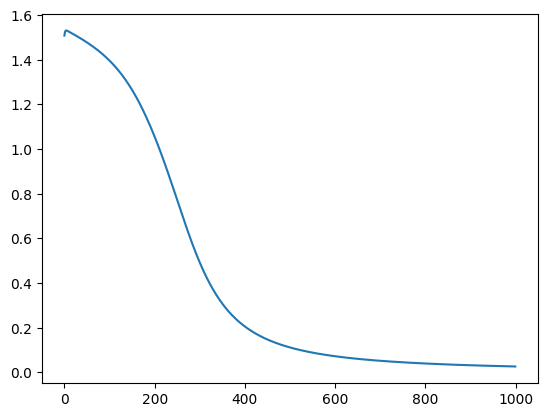

In [7]:
# Plot error during training
plt.plot(range(N_epochs),error_overTime)